In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from scipy.spatial.distance import mahalanobis
import scipy
from scipy import stats
import math

# READING DATA INTO NOTEBOOK

In [2]:
### reading data into notebook
train_identity = pd.read_csv(r'train_identity.csv')
test_identity = pd.read_csv(r'test_identity.csv')
test_transaction = pd.read_csv(r'test_transaction.csv')
train_transaction = pd.read_csv(r'train_transaction.csv')

trainDF = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
testDF = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

#print features
print("Features in train:\n", trainDF.columns.tolist())
print(trainDF.dtypes)
print("\nFeatures in test:\n", testDF.columns.tolist())
print(testDF.dtypes)

Features in train:
 ['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V7

# Fraud vs Non-Fraud Counts

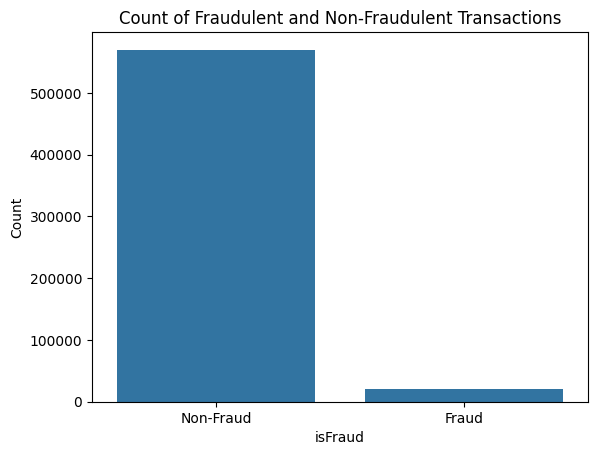

Percentage of Fraudulent Transactions: 0.03499000914417313


In [3]:
#Showing Distribution of Fraudulent vs Non-Fraudulent Transactions
fraud_counts = trainDF['isFraud'].value_counts()
sns.barplot(x=fraud_counts.index.map({0:"Non-Fraud", 1:"Fraud"}), y=fraud_counts.values)
plt.ylabel('Count')
plt.title('Count of Fraudulent and Non-Fraudulent Transactions')
plt.show()
print("Percentage of Fraudulent Transactions:", trainDF.isFraud.mean())
#Around 4 percent is flagged fraud 

In [4]:
#Correlation between transaction amount and fraudulent classification of transactions.
correlation = trainDF['TransactionAmt'].corr(trainDF['isFraud'])
print("Correlation between transaction amount and fraud flag:", correlation)

Correlation between transaction amount and fraud flag: 0.01131982533321524


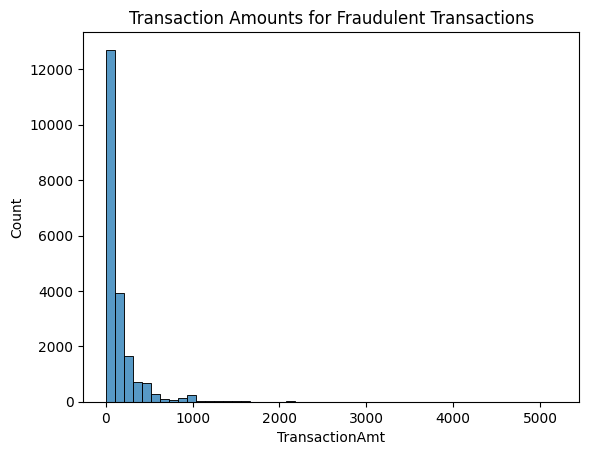

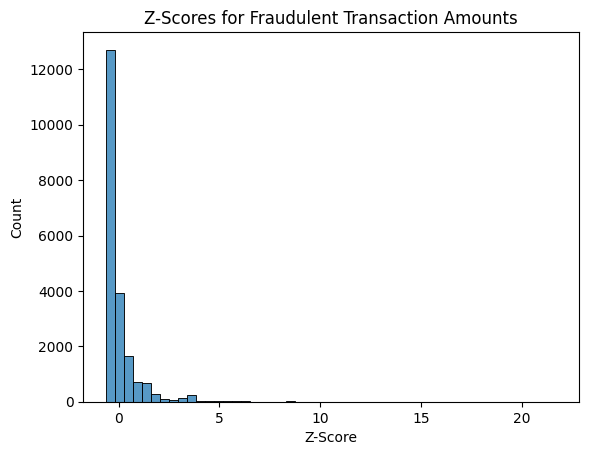

In [5]:
#Graphs of Transaction Amounts of Fraudulent Transactions + Z-scores for Fraudulent Transaction Amounts
fraudulent_transactions = trainDF[trainDF['isFraud']==1]
transaction_amounts = fraudulent_transactions['TransactionAmt']
z_scores = stats.zscore(transaction_amounts)

outliers = fraudulent_transactions[(z_scores > 3)|(z_scores < -3)]

sns.histplot(transaction_amounts, bins=50)
plt.title('Transaction Amounts for Fraudulent Transactions')
plt.show()

sns.histplot(z_scores, bins=50)
plt.title('Z-Scores for Fraudulent Transaction Amounts')
plt.xlabel('Z-Score')
plt.show()

In [6]:
#Ratio of Fraud Transactions in Long-Tail Transactions by Transaction Amount
long_tail_threshold = trainDF['TransactionAmt'].quantile(0.99)
long_tail_data = trainDF[trainDF['TransactionAmt'] > long_tail_threshold]
long_tail_fraud_ratio = long_tail_data['isFraud'].mean()
print(f"Fraud Ratio in Long-Tail Transactions: {long_tail_fraud_ratio}")

Fraud Ratio in Long-Tail Transactions: 0.024109200496365894


# Normalizing Transaction Amounts for Standard Deviation Analysis

In [7]:
mean_transaction_amt = trainDF['TransactionAmt'].mean()
std_transaction_amt = trainDF['TransactionAmt'].std()
trainDF['TransactionAmt_Zscore'] = (trainDF['TransactionAmt'] - mean_transaction_amt) / std_transaction_amt
print(trainDF[['TransactionAmt', 'TransactionAmt_Zscore']].head())
outliersZScore = trainDF[(trainDF['TransactionAmt_Zscore'] > 3) | (trainDF['TransactionAmt_Zscore'] < -3)]
print(f"Number of outliers: {outliersZScore.shape[0]}")
print(outliersZScore[['TransactionID', 'TransactionAmt', 'TransactionAmt_Zscore']])

   TransactionAmt  TransactionAmt_Zscore
0            68.5              -0.278167
1            29.0              -0.443327
2            59.0              -0.317889
3            50.0              -0.355520
4            50.0              -0.355520
Number of outliers: 10093
        TransactionID  TransactionAmt  TransactionAmt_Zscore
60            2987060         2454.00               9.696222
110           2987110         1153.95               4.260378
133           2987133         2594.95              10.285570
135           2987135         3000.00              11.979188
163           2987163          973.95               3.507752
...               ...             ...                    ...
590402        3577402         1331.00               5.000670
590405        3577405         2286.27               8.994899
590408        3577408         1615.74               6.191241
590464        3577464         1731.30               6.674427
590519        3577519         1659.95               6.376

# Checking Null Value Percentages and Organizing Groups of Fields

In [8]:
#showing columns with # entries > 80% being null/empty
trainDF.isnull().mean()[trainDF.isnull().mean() > .8]

dist2    0.936284
D6       0.876068
D7       0.934099
D8       0.873123
D9       0.873123
           ...   
id_27    0.991247
id_30    0.868654
id_32    0.868619
id_33    0.875895
id_34    0.868248
Length: 74, dtype: float64

In [9]:
#Remove Non-Numerical columns to prepare for further analysis
variableGroups = ['Transaction', 'card', 'addr', 'dist', 'email','Product', '^C', '^(D[0-9])', '^M', '^V', 'id', 'Device']
colGrouping = []
for i in variableGroups:
    matching_columns = trainDF.filter(regex=(i)).columns.to_list()
    colGrouping.append(matching_columns)
print(colGrouping)


[['TransactionID', 'TransactionDT', 'TransactionAmt', 'TransactionAmt_Zscore'], ['card1', 'card2', 'card3', 'card4', 'card5', 'card6'], ['addr1', 'addr2'], ['dist1', 'dist2'], ['P_emaildomain', 'R_emaildomain'], ['ProductCD'], ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14'], ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15'], ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'], ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77

# PCA Analysis

In [10]:
#PCA 1D
numeric_cols_train = trainDF.select_dtypes('number')
#separate isFraud into Y component of PCA
x1D = numeric_cols_train.fillna(numeric_cols_train.mean())
x1D.drop(['isFraud'], axis = 1)
y1D = trainDF['isFraud'] #target for later
#scale X component
X1D_scaled = MinMaxScaler().fit_transform(x1D)#scale due to sensitivity of PCA
#start PCA
pca = PCA(n_components = 2)
PCA_component = pca.fit_transform(X1D_scaled)
print(pca.explained_variance_ratio_)
# first component captures around 13.5% of variance in original data, second component captures around 12% of data

[0.13507436 0.12006169]


# Isolation Forest Analysis

In [11]:
# Create Isolation Forest and fit it based on the training data.
forest = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(0.1), \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=15, verbose=0)
isolationForestTrain = numeric_cols_train.fillna(numeric_cols_train.mean())
forest.fit(isolationForestTrain)
# Generate predictions based on the Isolation Forest
predictions = forest.predict(isolationForestTrain)
print("Normal: ", np.sum(predictions == 1), "Anomalies: ", np.sum(predictions == -1))

Normal:  531486 Anomalies:  59054


# Model Training after Isolation Forest Anomaly Removal 

In [33]:
cleaned_trainDF_Isolation = numeric_cols_train[predictions == 1]
X_cleaned_Isolation = cleaned_trainDF_Isolation.drop(columns=['isFraud'])  # Features
y_cleaned_Isolation = trainDF.loc[cleaned_trainDF_Isolation.index, 'isFraud']  # Target
X_train_isolation, X_test_isolation, y_train_isolation, y_test_isolation = train_test_split(X_cleaned_Isolation, y_cleaned_Isolation, test_size=0.3, random_state=0, stratify=y_cleaned_Isolation)
model = RandomForestClassifier(n_estimators=50, random_state=0, max_depth=10)
model.fit(X_train_isolation, y_train_isolation)
y_pred_isolation = model.predict(X_test_isolation)
print("Accuracy:", accuracy_score(y_test_isolation, y_pred_isolation))
print("Classification Report:\n", classification_report(y_test_isolation, y_pred_isolation))

Accuracy: 0.9777604957164181
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    155769
           1       0.92      0.04      0.07      3677

    accuracy                           0.98    159446
   macro avg       0.95      0.52      0.53    159446
weighted avg       0.98      0.98      0.97    159446



# Mahalanobis Outlier Detection

In [20]:
numeric_cols_train = trainDF.select_dtypes('number')
numeric_cols_train = numeric_cols_train.fillna(numeric_cols_train.mean())
cov_matrix = np.cov(numeric_cols_train.values.T)
inv_cov_matrix = np.linalg.inv(cov_matrix)
mean_values = numeric_cols_train.mean(axis=0).values
mahalanobis_distances = numeric_cols_train.apply(lambda row: mahalanobis(row, mean_values, inv_cov_matrix), axis=1)
numeric_cols_train['Mahalanobis_Distance'] = mahalanobis_distances
threshold = np.percentile(mahalanobis_distances, 97.5)
numeric_cols_train['Is_Outlier'] = numeric_cols_train['Mahalanobis_Distance'] > threshold
outliers = numeric_cols_train[numeric_cols_train['Is_Outlier'] == True]
outlier_count = numeric_cols_train['Is_Outlier'].sum()

/Users/ferrisatassi/opt/miniconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1035: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)
/var/folders/8n/l_2zns4502ggdwb9_1j1mw8h0000gn/T/ipykernel_861/212830275.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  numeric_cols_train['Mahalanobis_Distance'] = mahalanobis_distances
/var/folders/8n/l_2zns4502ggdwb9_1j1mw8h0000gn/T/ipykernel_861/212830275.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  numeric_cols_train['Is_Outlier'] = numeric_cols_trai

# Model Training after Mahalnobis Outlier Removal

In [26]:
cleaned_trainDF = numeric_cols_train[numeric_cols_train['Is_Outlier'] == False]
cleaned_trainDF = cleaned_trainDF.drop(columns=['Mahalanobis_Distance', 'Is_Outlier'])
X = cleaned_trainDF.drop(columns=['isFraud'])  # Features
y = trainDF.loc[cleaned_trainDF.index, 'isFraud']  # Target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0, stratify=y)
model = RandomForestClassifier(n_estimators=50, random_state=0, max_depth=10)  # You can adjust n_estimators as needed
model.fit(X_train, y_train) 

RandomForestClassifier(max_depth=10, n_estimators=50, random_state=0)

In [31]:
y_pred = model.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Confusion Matrix:
[[170845    118]
 [  4547   1652]]
Accuracy: 0.9737
